In [45]:

import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import string
from bidi.algorithm import get_display
from farasa.stemmer import FarasaStemmer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from keras.layers import (Dense, Embedding, Reshape, Activation, 
                          SimpleRNN, LSTM, Convolution1D, 
                          MaxPooling1D, Dropout, Bidirectional)
import keras
from keras.models import Sequential, Model
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import model_to_dot, plot_model
from tensorflow.keras.optimizers import SGD
from keras.preprocessing import sequence
from wordcloud import WordCloud
from nltk.corpus import stopwords
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import BatchNormalization
import gensim
from gensim.models import KeyedVectors
from gensim.models import word2vec
import arabic_reshaper
from arabic_reshaper import reshape
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer


In [46]:

dataset = pd.read_csv(r'C:\Users\Blank\OneDrive\Desktop\RES1.csv') 
dataset.head(100)

,polarity,text,restaurant_id,user_id
0,-1,اولا: المنيو تغير الشورما اصبحت اعتياديه بأختف...,296,423
1,-1,من محلات الشاورما ذات الشعبيه لتميز الصلصات ال...,296,423
2,1,دجاج طازج يحضر امامك على الطلب لا يقوم باعدة ا...,5027,39580
3,1,فكما تعرف أستراليا بالكنغر والكوالا. فإنها تعر...,642,444
4,-1,إسمحو لي أن أقيم مطعم هاشم بصفتي فلسطيني عشت ف...,434,2191
...,...,...,...,...
95,1,حلو وخفيف واهم شي نظيف \n \n بعدين اختار على ...,68,6896
96,1,حلو وخفيف \n \n بعنب مو دسم \n \n وحلو اني ا...,68,6896
97,1,بصراحة المطعم ما عليه \n \n وله زبائنه الخاصي...,68,6348
98,1,اسعاره مرتفعه لكن يستحق \n من افضل البرجر الل...,1412,28474


In [47]:
# There are 8328 reviews in the dataset
len(dataset)

8364

In [48]:
dataset.columns

Index(['polarity', 'text', 'restaurant_id', 'user_id'], dtype='object')

In [49]:
#cheack for null
dataset.isnull().sum()


polarity         0
text             0
restaurant_id    0
user_id          0
dtype: int64

In [50]:
dataset.drop_duplicates(inplace=True)

In [51]:
for index,text in enumerate(dataset['text'][0:3]):
  print('Review %d:\n'%(index+1),text)

Review 1:
 اولا: المنيو تغير الشورما اصبحت اعتياديه بأختفاء الصلصات والخيارات  
 ثانيا : في المره الاولي لطلبي وجدنا قطعه من قفاز الايدي في الدجاج واعتقدنا مبدأيا بأنه من جلد الدجاج  حتي تأكدنا ومنه قررنا ان لا نشتري منه لكن -للبطن احكام :-) 
 ثالثا : طلبت بالمره الاخيره الطبق المفضل لي صحن الشورما (شورما بالتر ) فجاء الطلب من غير خبز او صلصه ولا مجال للعوده للمحل والشكوي  
 قرار اخير لا اطلب من اكسبرس مجددا
Review 2:
 من محلات الشاورما ذات الشعبيه لتميز الصلصات المقدمه معها يمكن اختيار الشاورما بالصلصات المنوعه (مكسيكيه,فرنسيه,ايطاليه,هنديه,صينيه,بحرينيه,لبنانيه,يابانيه,الباربيكيو,الحاره,العربيه)  
 افضل تناول صحن الشاورما   shawama plater يكون معاها شاورما لحم ودجاج حسب طلبك و4 خبز صاحج وتختار نوعين من الصوص وبطاطس وسلطه ومشروب  
 يعتبر مطعم شبابي لا مكان لجلوس العائله فيه يعني دايم تيك اوي ويفتح لساعات متأخره  
 يستحق التجربه  
  http://www.shawarmaxpress.com/
Review 3:
 دجاج طازج يحضر امامك على الطلب لا يقوم باعدة التسخين تاخذه مباشرة بعد القلي يحضر عند الطلب يفضل الاتصال مسبقا نكه

In [52]:
# Note that the dataset has mostly positive reviews
dataset.polarity.value_counts(normalize=True)

 1    0.710975
-1    0.289025
Name: polarity, dtype: float64

In [53]:
# normlzation and remove non Arabic charctrcers 
dataset['cleaned'] = dataset['text'].astype(str).apply(lambda x: re.sub('\w*\d\w*','', x))
dataset['cleaned'] = dataset['cleaned'].apply(lambda x: re.sub('\d','',x))
dataset['cleaned'] = dataset['cleaned'].replace("ؤ","و") 
dataset['cleaned'] = dataset['cleaned'].replace("[أإآ]","ا")
dataset['cleaned'] = dataset['cleaned'].replace("ى","ي")
dataset['cleaned'] = dataset['cleaned'].replace("ة","ه")
dataset['cleaned'] = dataset['cleaned'].replace('','آ')
dataset['cleaned'] = dataset['cleaned'].replace('','ء')
dataset['cleaned'] = dataset['cleaned'] .apply(lambda x:re.findall('[\u0600-\u06ff]+', x))

# remove stopwords 
stop=stopwords.words('arabic')
dataset['cleaned'] = dataset['cleaned'].apply(lambda x: [item for item in x if item not in stop])
# remove punctuation
dataset['cleaned'] = dataset['cleaned'].astype(str).apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

#retrive stem
#stemmer = FarasaStemmer()
#dataset['cleaned'] = dataset['cleaned'].apply(lambda x: [stemmer.stem(y) for y in x])
dataset['cleaned']

0       اولا المنيو تغير الشورما اصبحت اعتياديه بأختفا...
1       محلات الشاورما الشعبيه لتميز الصلصات المقدمه م...
2       دجاج طازج يحضر امامك الطلب يقوم باعدة التسخين ...
3       فكما تعرف أستراليا بالكنغر والكوالا فإنها تعرف...
4       إسمحو أقيم مطعم هاشم بصفتي فلسطيني عشت الأردن ...
                              ...                        
8359    أتمنى تعملو بطاقات ذهبية للعملاء الدائمين يكون...
8360    المشويات عندهم اطيب مشويات اكلتها بحياتي والاس...
8361    المطعم ممتاز للغايه ، ناحيه تجهيزات المطعم ، و...
8362    جينا عندهم الساعة بالليل مافى احد اتبرع يشوفلن...
8363    اذا اللي بالشارع التجاري اوووه ماشاء الله والل...
Name: cleaned, Length: 8328, dtype: object

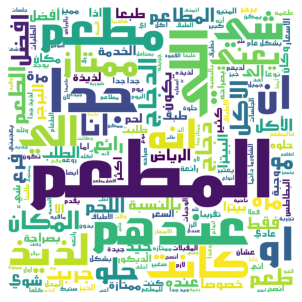

In [54]:
  
positive=dataset[dataset.polarity == 1]
reshaped_text = arabic_reshaper.reshape(' '.join(positive['cleaned'] ))
artext = get_display(reshaped_text)

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(artext)
                   
# plot the WordCloud image                      
plt.figure()
plt.imshow(wordcloud )
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

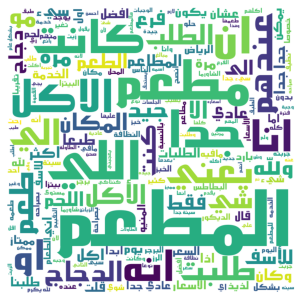

In [55]:
negative=dataset[dataset.polarity == -1]
reshaped_text = arabic_reshaper.reshape(' '.join(negative['cleaned'] ))
artext = get_display(reshaped_text)

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(artext)
 
# plot the WordCloud image                      
plt.figure()
plt.imshow(wordcloud )
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [56]:
#integer encode the labels
y=dataset['polarity'].values
encoder = OneHotEncoder()
y = encoder.fit_transform(y.reshape(-1, 1)).toarray()
dataset.polarity

0      -1
1      -1
2       1
3       1
4      -1
       ..
8359    1
8360    1
8361    1
8362   -1
8363    1
Name: polarity, Length: 8328, dtype: int64

In [57]:
#vectrraized by TFIDF
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(dataset['cleaned'],dataset.polarity, 
                                                    test_size=0.2, random_state = 42)
tfidf_vect = TfidfVectorizer(decode_error = 'ignore')
X_train_2 = tfidf_vect.fit_transform(X_train_2).todense()
X_test_2 = tfidf_vect.transform(X_test_2).todense()
x_train_complete=tfidf_vect.fit_transform(dataset['cleaned']).todense()


In [58]:

# Create a function to calculate the error metrics, since we'll be doing this several times

def conf_matrix(actual, predicted):
    cm = confusion_matrix(actual, predicted)
    sns.heatmap(cm, xticklabels=['predicted_negative', 'predicted_positive'], 
                yticklabels=['actual_negative', 'actual_positive'], annot=True,
                fmt='d', annot_kws={'fontsize':20}, cmap="YlGnBu");

    true_neg, false_pos = cm[0]
    false_neg, true_pos = cm[1]

    accuracy = round((true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg),3)
    precision = round((true_pos) / (true_pos + false_pos),3)
    recall = round((true_pos) / (true_pos + false_neg),3)
    f1 = round(2 * (precision * recall) / (precision + recall),3)

    cm_results = [accuracy, precision, recall, f1]
    return cm_results


In [59]:
# Train the first mode Logistic Regression
lr = LogisticRegression(C = 100,max_iter=1000)
lr.fit(X_train_2, y_train_2)
scores1 = cross_val_score(lr, x_train_complete, dataset.polarity, cv=5)
print('Simple logistic score: {}'.format(lr.score(X_test_2, y_test_2)))
LR_scores=np.average(scores1)
print('NB avarage cross validation score of 5 iterations: {}'.format(LR_scores))

Simple logistic score: 0.8433373349339736
NB avarage cross validation score of 5 iterations: 0.8345359044518708


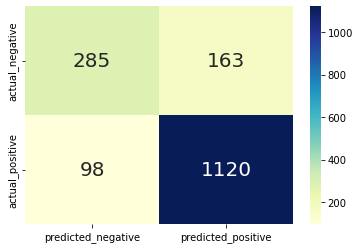

In [60]:
#Create heat map of Logistic Regression
y_pred = lr.predict(X_test_2)
cm1 = conf_matrix(y_test_2, y_pred)

In [61]:
#Create a Naive bayes Classifier
bnb = BernoulliNB()
bnb.fit(X_train_2, y_train_2)
print('Naive Bayes score: {}'.format(bnb.score(X_test_2, y_test_2)))
scores2 = cross_val_score(bnb, x_train_complete, dataset.polarity, cv=5)
NB_scores=np.average(scores2)
print('NB avarage cross validation score of 5 iterations: {}'.format(NB_scores))

Naive Bayes score: 0.7563025210084033
NB avarage cross validation score of 5 iterations: 0.7271865142453378


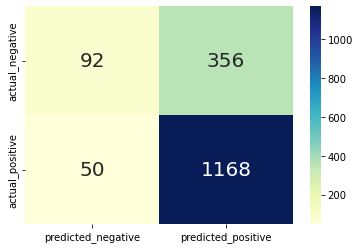

In [62]:
#Create heat map of a a Naive bayes Classifier
y_pred_nb = bnb.predict(X_test_2)
cm2 = conf_matrix(y_test_2, y_pred_nb)

In [63]:
#Create a svm Classifier
clf = svm.SVC(kernel='linear') 
clf.fit(X_train_2, y_train_2)
scores3 = cross_val_score(clf, x_train_complete, dataset.polarity, cv=5)
SVM_scores=np.average(scores3)
print('SVM score: {}'.format(clf.score(X_test_2, y_test_2)))
print('SVM cross validation score of 5 iterations: {}'.format(SVM_scores))


SVM score: 0.8493397358943577
SVM cross validation score of 5 iterations: 0.8419815493765075


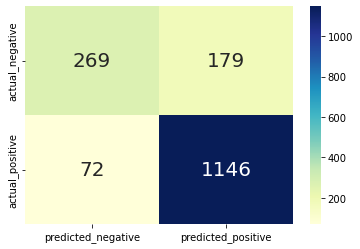

In [64]:
#Create heat map of a svm Classifier
y_pred_clf = clf.predict(X_test_2)
cm3 = conf_matrix(y_test_2, y_pred_clf)

In [65]:
# Compile all of the error metrics into a dataframe for comparison
results = pd.DataFrame(list(zip(cm1,cm2,cm3)))
results = results.set_index([['Accuracy', 'Precision', 'Recall', 'F1 Score']])
results.columns = ['LogReg','Naivebays','   SVM ']
results                                                                                                                                                                

,LogReg,Naivebays,SVM
Accuracy,0.843,0.756,0.849
Precision,0.873,0.766,0.865
Recall,0.920,0.959,0.941
F1 Score,0.896,0.852,0.901


In [66]:
# Compile all of iteration into a dataframe for comparison
results = pd.DataFrame(list(zip(scores1,scores2,scores3)))
results = results.set_index([['Iteration_1','Iteration_2','Iteration_3','Iteration_4','Iteration_5']])
results.columns = ['LogReg','Naivebays','   SVM ']
results  


,LogReg,Naivebays,SVM
Iteration_1,0.807923,0.735294,0.821128
Iteration_2,0.845738,0.722689,0.842137
Iteration_3,0.834934,0.714286,0.840336
Iteration_4,0.850450,0.732132,0.859459
Iteration_5,0.833634,0.731532,0.846847


In [67]:
seq_len = 300 # standardized length of each word sequence 
max_vocab = 3000 # max number of words to consider when tokenizing (based on freq)

# fit tokenizer vocab (note that it lowercases and strips punct)
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(dataset['cleaned'])

# standard train/val split
train_text, val_text, ytrain, y_val = train_test_split(dataset['cleaned'],y, 
                                                        test_size=0.2, random_state = 42)

# convert train and val texts to token sequences of standardized length 100,
# padding fills leading 0s in or cuts off sequence at 100th word
train_text = tokenizer.texts_to_sequences(train_text) 
train_text = pad_sequences(train_text, maxlen=seq_len)

val_text = tokenizer.texts_to_sequences(val_text)
val_text = pad_sequences(val_text, maxlen=seq_len)

train_text[2]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [68]:
#vacabulary size in dataset
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

45687


In [69]:

# Neural network

input_dim = train_text.shape[1]
model = keras.Sequential()
model.add(Dense(20, input_dim=input_dim, activation='relu'))#input layer input_dim has to match No. of Features!!!
model.add(Dropout(.5))
model.add(Dense(10, activation='relu'))#Hidder Layer 1
model.add(Dropout(.5))#Hidder Layer 1
model.add(Dense(2, activation='softmax'))#Output Layer --> Output has to match the number of categories in target!!!!
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print('Train...')
history = model.fit(train_text, ytrain, 
                 validation_data=(val_text, y_val),
                 epochs=10, batch_size=64, verbose=1)

score1, acc1 =model.evaluate(val_text, y_val,
                                 batch_size=64)
print('Train...')
print('Test score:', score1)
print('Test accuracy:', acc1)


Train...
Epoch 1/10
105/105 [==============================] - 2s 12ms/step - loss: 66.4820 - accuracy: 0.5663 - val_loss: 3.3814 - val_accuracy: 0.7089
Epoch 2/10
105/105 [==============================] - 0s 791us/step - loss: 14.1829 - accuracy: 0.6312 - val_loss: 0.8808 - val_accuracy: 0.7305
Epoch 3/10
105/105 [==============================] - 0s 951us/step - loss: 6.3934 - accuracy: 0.6497 - val_loss: 0.7092 - val_accuracy: 0.7305
Epoch 4/10
105/105 [==============================] - 0s 861us/step - loss: 3.6562 - accuracy: 0.6594 - val_loss: 0.6075 - val_accuracy: 0.7311
Epoch 5/10
105/105 [==============================] - 0s 839us/step - loss: 2.5636 - accuracy: 0.6783 - val_loss: 0.5954 - val_accuracy: 0.7311
Epoch 6/10
105/105 [==============================] - 0s 842us/step - loss: 1.8776 - accuracy: 0.6908 - val_loss: 0.5921 - val_accuracy: 0.7305
Epoch 7/10
105/105 [==============================] - 0s 803us/step - loss: 1.3228 - accuracy: 0.6888 - val_loss: 0.5877 - val

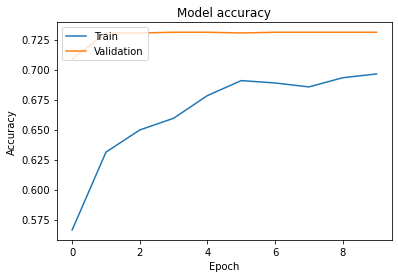

In [70]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.yscale('linear')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [71]:
#use pre train word embeddings
# load the word embedding 
w2v_embeddings_index={}
Total_Embedding_Dim=300
embeddings_file='C:/Users/Blank/OneDrive/Desktop/full_uni_sg_300_twitter.mdl'

w2v_model =KeyedVectors.load(embeddings_file)
for word in w2v_model.wv.key_to_index:
    w2v_embeddings_index[word] = w2v_model.wv[word]
print('Loaded %s word vectors' % len(w2v_embeddings_index))



Loaded 1259756 word vectors


In [72]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, Total_Embedding_Dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = w2v_embeddings_index.get(word)
if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector
print('Embedding Matrix shape:' , embedding_matrix.shape)


Embedding Matrix shape: (45687, 300)


In [73]:
# Set parameters

maxlen = 300  # cut texts after this number of words (among top max_features most common words)


# Build our model!
print('Build model...')
lstm_model = Sequential()

# Here's the LSTM model!
#lstm_model.add(Embedding(vocab_size,Total_Embedding_Dim, weights=[embedding_matrix], input_length=300,trainable=True))
lstm_model.add(Embedding(vocab_size, input_length=300,output_dim=300))
lstm_model.add(LSTM(100, recurrent_dropout=.5))
lstm_model.add(Dense(50))
lstm_model.add(Dropout(.5))
lstm_model.add(BatchNormalization())
lstm_model.add(Dense(2))
lstm_model.add(Activation('softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

lstm_model.compile( loss = "categorical_crossentropy", optimizer = 'sgd', 
            metrics=['accuracy'])

# try using different optimizers and different optimizer configs
#lstm_model.compile(loss='categorical_crossentropy',
             # optimizer='adam',
             # metrics=['accuracy'])

print('Train...')
history = lstm_model.fit(train_text, ytrain, 
                 validation_data=(val_text, y_val),
                 epochs=30, batch_size=64, verbose=1)

score, acc = lstm_model.evaluate(val_text, y_val,
                                 batch_size=64)
print('Train...')
print('Test score:', score)
print('Test accuracy:', acc)

Build model...
Train...
Epoch 1/30
105/105 [==============================] - 94s 885ms/step - loss: 0.5923 - accuracy: 0.6767 - val_loss: 0.5455 - val_accuracy: 0.7311
Epoch 2/30
105/105 [==============================] - 101s 960ms/step - loss: 0.3553 - accuracy: 0.8488 - val_loss: 0.4712 - val_accuracy: 0.7761
Epoch 3/30
105/105 [==============================] - 100s 952ms/step - loss: 0.2561 - accuracy: 0.8951 - val_loss: 0.4257 - val_accuracy: 0.8259
Epoch 4/30
105/105 [==============================] - 100s 952ms/step - loss: 0.1932 - accuracy: 0.9213 - val_loss: 0.5092 - val_accuracy: 0.8067
Epoch 5/30
105/105 [==============================] - 100s 954ms/step - loss: 0.1499 - accuracy: 0.9428 - val_loss: 0.6477 - val_accuracy: 0.8043
Epoch 6/30
105/105 [==============================] - 101s 963ms/step - loss: 0.1206 - accuracy: 0.9541 - val_loss: 0.7727 - val_accuracy: 0.7947
Epoch 7/30
105/105 [==============================] - 102s 970ms/step - loss: 0.0956 - accuracy: 0.96

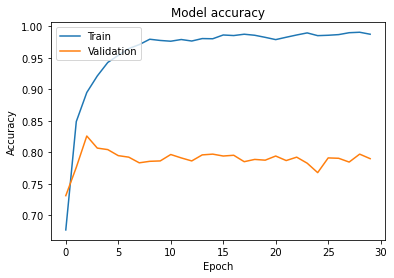

In [74]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.yscale('linear')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [75]:

print('Conclusion:The best results are achieved by SVM that superior all traditional approches as well as LSTM with a pretrained model.This may be because of the limitation size in our dataset')

Conclusion:The best results are achieved by SVM that superior all traditional approches as well as LSTM with a pretrained model.This may be because of the limitation size in our dataset
